# Grad-CAM
visualize attention of the network

In [1]:
from gradCam.VAE_grad_cam import *
from gradCam.vis_util import *
# from LinearVAE_grad_cam import *

import sys
sys.path.append("../Reconstruction/")
import cv2
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np

In [2]:
import os
import shutil
import time

import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.distributed as dist
import torch.optim
# import torch.utils.data
import torch.utils.data as data
import torch.utils.data.distributed
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils.data.sampler import SubsetRandomSampler
# import models
# import utils.flops as flops

# import Reconstruction.models as models



import argparse, os, pickle, glob, cv2
import matplotlib.pyplot as plt
import numpy as np

from utils.loss_function import select_loss_function
from utils.get_cdim import update_code_dim

from data.dataset import StanfordDog
from Solver import LinearSolver, ConvSolver

from models.simpleAE import simpleAE
from models.LinearVAE import LinearVAE
from models.ConvVAE import ConvVAE

from torchvision.datasets import MNIST
from scipy.stats import norm

from copy import deepcopy

In [3]:
channel = 3
picReslu = 96
model = ConvVAE(c_dim=update_code_dim(128, picReslu, 4), z_dim=1024, num_channels=channel) # the update_code_dim means(num_filters_in_final_layer, img_size, num_conv_layers)
model = model.cuda()
checkpoints = glob.glob(pathname='../Reconstruction/r{}_dog_check/ConvVAE*'.format(picReslu))
if len(checkpoints) != 0:
    model.load(path=checkpoints[0])
    print("loaded:", checkpoints[0])

loaded: ../Reconstruction/r96_dog_check/ConvVAE_0602_L4_Z1024.pth


In [4]:
def preprocess(image_path):
    raw_image = cv2.imread(image_path)
    raw_image = cv2.resize(raw_image, (picReslu,) * 2) # this 32 is correspondent to the 32 in c_dim
    image = transforms.Compose(
        [
            transforms.ToTensor(),
        ]
    )(raw_image[..., ::-1].copy())
    return image, raw_image

In [5]:
images = []
raw_images = []
print("Images:")
#####IMAGES FOR DOG #######
image_paths = ["../Reconstruction/data/Images/n02090622-borzoi/n02090622_3615.jpg"]#,"cat_dog.png"]
image_paths = ["../Reconstruction/data/Images/n02090622-borzoi/n02090622_3615.jpg"]#,"cat_dog.png"]

for i, image_path in enumerate(image_paths):
    print("\t#{}: {}".format(i, image_path))
    image, raw_image = preprocess(image_path)
    images.append(image)
    raw_images.append(raw_image)

images = torch.stack(images).cuda()

##### IMAGES FOR MNIST #####
# train_loader = torch.utils.data.DataLoader(dataset=MNIST('../Reconstruction/data/{0}'.format("mnist"), train=True,download=True ,transform=transforms.Compose([transforms.Resize(32), transforms.ToTensor()])), batch_size=1, shuffle=True)
# images, _ = next(iter(train_loader))
# raw_images = images

Images:
	#0: ../Reconstruction/data/Images/n02090622-borzoi/n02090622_3615.jpg


###P###: (5, 13)
torch.Size([1, 3, 96, 96])
outshape: (1, 3, 96, 96)
torch.Size([1, 3, 96, 96])


/home/hexpodmlc/anaconda3/lib/python3.6/site-packages/torch/tensor.py:287: UserWarning: non-inplace resize is deprecated
  warnings.warn("non-inplace resize is deprecated")


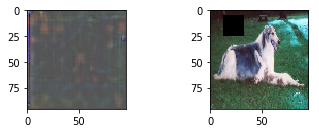

###P###: (40, 10)
torch.Size([1, 3, 96, 96])
outshape: (1, 3, 96, 96)
torch.Size([1, 3, 96, 96])


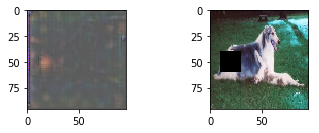

###P###: (15, 45)
torch.Size([1, 3, 96, 96])
outshape: (1, 3, 96, 96)
torch.Size([1, 3, 96, 96])


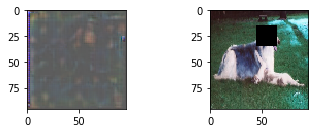

###P###: (60, 60)
torch.Size([1, 3, 96, 96])
outshape: (1, 3, 96, 96)
torch.Size([1, 3, 96, 96])


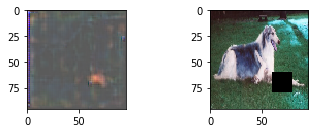

###P###: (10, 70)
torch.Size([1, 3, 96, 96])
outshape: (1, 3, 96, 96)
torch.Size([1, 3, 96, 96])


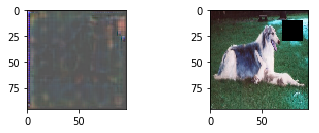

In [8]:
def area_grad_cam(images, raw_images, pos, size = (6,6)):
    
    bp = GuidedBackPropagation(model=model)
    print(images.shape)
    out = bp.forward(images)
    out = out.cpu().detach().numpy()
    print("outshape:",out.shape)

    bp.backward(pos = pos, size = size)
    gradients = bp.generate()
    gradient = gradients[0]
    
    plt.subplot(221)
    plt.imshow(img_gradient(gradient))#,"gray")
    plt.subplot(222)
    plt.imshow(img_blockedArea(raw_images,pos,size)[0])
    plt.show()
for p in [(5,13),(40,10),(15,45),(60,60),(10,70)]:
    print("###P###:",p)
    area_grad_cam(images, raw_images,pos = np.array([[*p]]), size = (20,20))

LAYER:  4
raw_shape: (1, 96, 96, 3)
torch.Size([1, 3, 96, 96])
torch.Size([1, 3, 96, 96])
torch.Size([1, 3, 96, 96])


/home/hexpodmlc/anaconda3/lib/python3.6/site-packages/torch/tensor.py:287: UserWarning: non-inplace resize is deprecated
  warnings.warn("non-inplace resize is deprecated")


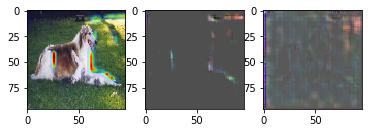

LAYER:  5
raw_shape: (1, 96, 96, 3)
torch.Size([1, 3, 96, 96])
torch.Size([1, 3, 96, 96])
torch.Size([1, 3, 96, 96])


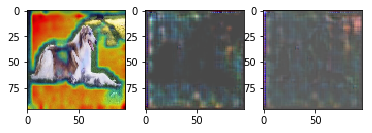

LAYER:  6
raw_shape: (1, 96, 96, 3)
torch.Size([1, 3, 96, 96])
torch.Size([1, 3, 96, 96])
torch.Size([1, 3, 96, 96])


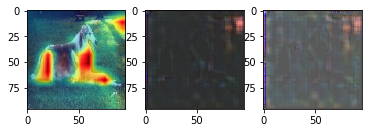

LAYER:  7
raw_shape: (1, 96, 96, 3)
torch.Size([1, 3, 96, 96])
torch.Size([1, 3, 96, 96])
torch.Size([1, 3, 96, 96])


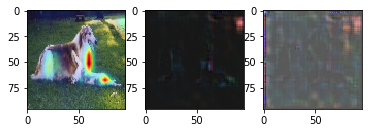

LAYER:  8
raw_shape: (1, 96, 96, 3)
torch.Size([1, 3, 96, 96])
torch.Size([1, 3, 96, 96])
torch.Size([1, 3, 96, 96])


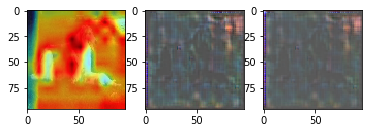

LAYER:  9
raw_shape: (1, 96, 96, 3)
torch.Size([1, 3, 96, 96])
torch.Size([1, 3, 96, 96])
torch.Size([1, 3, 96, 96])


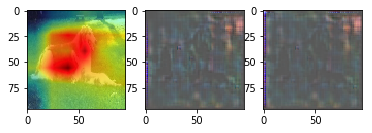

LAYER:  10
raw_shape: (1, 96, 96, 3)
torch.Size([1, 3, 96, 96])
torch.Size([1, 3, 96, 96])
torch.Size([1, 3, 96, 96])


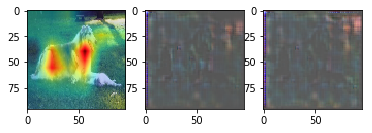

LAYER:  11
raw_shape: (1, 96, 96, 3)
torch.Size([1, 3, 96, 96])
torch.Size([1, 3, 96, 96])
torch.Size([1, 3, 96, 96])


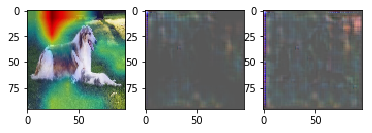

In [9]:
def grad_cam_layer(raw_images,layer):
    raws = np.array(raw_images)
    print("raw_shape:",raws.shape )
    raws = raws.transpose(0,3,1,2)
    images = torch.Tensor(raws).cuda()
    print(images.shape)

    gcam = GradCAM(model=model,candidate_layers=["Encoder.main.%d" %i for i in range(1,12)])
    _ = gcam.forward(images)

    gbp = GuidedBackPropagation(model=model)
    _ = gbp.forward(images)

    pos = np.array([[10,70]])
    size = (20,20)
    gbp.backward(pos,size)
    gradients = gbp.generate()

    # # Grad-CAM

    gcam.backward(pos,size)
    regions = gcam.generate(target_layer="Encoder.main.{}".format(layer))

    grad_gradients = torch.mul(regions, gradients)

    gcam = regions[0,0]

    plt.subplot(131)
    plt.imshow(img_gradcam(gcam,raw_images[0],True))
    plt.subplot(132)
    plt.imshow(img_gradient(grad_gradients[0]))
    plt.subplot(133)
    plt.imshow(img_gradient(gradients[0]))
    plt.show()
for i in range(4,12):
    print("LAYER: ",i)
    grad_cam_layer(raw_images,i)

In [66]:
for name, module in gbp.model.named_modules():
    print (name)


Encoder
Encoder.main
Encoder.main.0
Encoder.main.1
Encoder.main.2
Encoder.main.3
Encoder.main.4
Encoder.main.5
Encoder.main.6
Encoder.main.7
Encoder.main.8
Encoder.main.9
Encoder.main.10
Encoder.main.11
Encoder.linear_mu
Encoder.sigma
Decoder
Decoder.main_1
Decoder.main_1.0
Decoder.main_1.1
Decoder.main_1.2
Decoder.main_1.3
Decoder.main_2
Decoder.main_2.0
Decoder.main_2.1
Decoder.main_2.2
Decoder.main_2.3
Decoder.main_2.4
Decoder.main_2.5
Decoder.main_2.6
Decoder.main_2.7
Decoder.main_2.8
Decoder.main_2.9
Decoder.main_2.10


### debug the Grad-cam 不好看的问题

In [53]:
from grad_cam import *

import sys
sys.path.append("../Reconstruction/")
import cv2
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np

import os
import shutil
import time

import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.distributed as dist
import torch.optim
# import torch.utils.data
import torch.utils.data as data
import torch.utils.data.distributed
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils.data.sampler import SubsetRandomSampler

In [54]:
import copy
import os.path as osp

import cv2
import matplotlib.cm as cm
import numpy as np
import torch
import torch.hub
import torch.nn.functional as F
from torch.autograd import Variable
from torchvision import models, transforms

def get_device(cuda):
    cuda = cuda and torch.cuda.is_available()
    device = torch.device("cuda" if cuda else "cpu")
    if cuda:
        current_device = torch.cuda.current_device()
        print("Device:", torch.cuda.get_device_name(current_device))
    else:
        print("Device: CPU")
    return device

device = get_device(True)
model = models.__dict__["resnet18"](pretrained=True)
model.to(device)
model.eval()
for name, module in model.named_modules():
    print (name)

Device: TITAN Xp

conv1
bn1
relu
maxpool
layer1
layer1.0
layer1.0.conv1
layer1.0.bn1
layer1.0.relu
layer1.0.conv2
layer1.0.bn2
layer1.1
layer1.1.conv1
layer1.1.bn1
layer1.1.relu
layer1.1.conv2
layer1.1.bn2
layer2
layer2.0
layer2.0.conv1
layer2.0.bn1
layer2.0.relu
layer2.0.conv2
layer2.0.bn2
layer2.0.downsample
layer2.0.downsample.0
layer2.0.downsample.1
layer2.1
layer2.1.conv1
layer2.1.bn1
layer2.1.relu
layer2.1.conv2
layer2.1.bn2
layer3
layer3.0
layer3.0.conv1
layer3.0.bn1
layer3.0.relu
layer3.0.conv2
layer3.0.bn2
layer3.0.downsample
layer3.0.downsample.0
layer3.0.downsample.1
layer3.1
layer3.1.conv1
layer3.1.bn1
layer3.1.relu
layer3.1.conv2
layer3.1.bn2
layer4
layer4.0
layer4.0.conv1
layer4.0.bn1
layer4.0.relu
layer4.0.conv2
layer4.0.bn2
layer4.0.downsample
layer4.0.downsample.0
layer4.0.downsample.1
layer4.1
layer4.1.conv1
layer4.1.bn1
layer4.1.relu
layer4.1.conv2
layer4.1.bn2
avgpool
fc


In [57]:
def BGR_RGB(img):
    new_img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    return new_img

def save_gradient(filename, gradient):
    gradient = gradient.cpu().numpy().transpose(1, 2, 0)
    gradient -= gradient.min()
    gradient /= gradient.max()
    gradient *= 255.0
    plt.imshow( BGR_RGB(np.uint8(gradient)))
    plt.show()
    cv2.imwrite(filename, np.uint8(gradient))

def save_gradcam(filename, gcam, raw_image, paper_cmap=False):
    gcam = gcam.cpu().numpy()
    cmap = cm.jet_r(gcam)[..., :3] * 255.0
    if paper_cmap:
        alpha = gcam[..., None]
        gcam = alpha * cmap + (1 - alpha) * raw_image
    else:
        gcam = (cmap.astype(np.float) + raw_image.astype(np.float)) / 2
    plt.imshow( BGR_RGB(np.uint8(gcam)))
    plt.show()
    cv2.imwrite(filename, np.uint8(gcam))

	#0: ../Reconstruction/data/Images/n02090622-borzoi/n02090622_3615.jpg


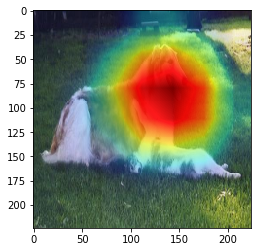

0.0


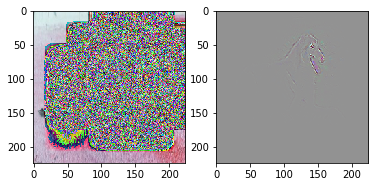

In [58]:
channel = 3
picReslu = 224
image_paths = ["../Reconstruction/data/Images/n02090622-borzoi/n02090622_3615.jpg"]#,"cat_dog.png"]
images,raw_images = [], []
for i, image_path in enumerate(image_paths):
    print("\t#{}: {}".format(i, image_path))
    image, raw_image = preprocess(image_path)
    images.append(image)
    raw_images.append(raw_image)

images = torch.stack(images).cuda()

gcam = GradCAM(model=model,candidate_layers=["layer4.1.conv2"])
_ = gcam.forward(images)

gbp = GuidedBackPropagation(model=model)
probs, ids  = gbp.forward(images)

# 前面忘了写 .removehook

gbp.backward(ids=ids[:, [i]])
gradients = gbp.generate()

# Grad-CAM
gcam.backward(ids=ids[:, [i]])
regions = gcam.generate(target_layer="layer4.1.conv2")

grad_gradients = torch.mul(regions, gradients)




gcam = regions[0,0]
save_gradcam("gradcam.png",gcam,raw_images[0],True )
gcam = gcam.cpu().numpy()

cmap = cm.jet_r(gcam)[..., :3] * 255.0

alpha = gcam[..., None]
print(alpha.min())
gcam = alpha * cmap + (1 - alpha) * raw_image

#     gcam = (cmap.astype(np.float) + raw_image.astype(np.float)) / 2
#     plt.imshow(raw_image)
plt.subplot(121)
plt.imshow(gcam)
plt.subplot(122)

gradient = grad_gradients[0]
save_gradient("gradient.png",gradient)
gradient = gradient.cpu().numpy().transpose(1, 2, 0)

gradient -= gradient.min()
gradient /= gradient.max()
gradient *= 255.0
#     print(gradient.shape)
gradient = np.uint8(gradient)

# plt.imshow(gradient)

# plt.show()